## CNN model implementation for AI-written text detection  
Nowadays, with rapid development of different LLM problem of detection AI-generated content remains one of the most topical. Being able to spot ai-generated text could help in separating honest works from cheating on exams, interviews, resolving copyright issues, for educational purposes.  
This project is created on bases of dataset which contains human and ai-written essays. There are 2700 texts (50% of each category) each labeled as ai-written (1) or human-written (0). Average essay length: 300–800 words  
While convolutional neural networks (CNNs) are most commonly applied in computer vision tasks, they have also been used in natural language processing to capture local textual patterns such as n-grams. This project investigates the effectiveness of a CNN-based model for binary text classification under controlled conditions. Given the uniform structure of the essays and the binary nature of the task, the dataset provides a suitable setting for evaluating the capabilities and limitations of CNNs in this context.

__source: https://www.kaggle.com/datasets/navjotkaushal/human-vs-ai-generated-essays__

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from TextPreprocessorCNN import TextPreprocessorCNN
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle
import re
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [43]:
df=pd.read_csv("balanced_ai_human_prompts.csv")
amount_gen=df["generated"].value_counts()
print(amount_gen)

generated
1    1375
0    1375
Name: count, dtype: int64


In [44]:
#dataset preprocession 
texts = df.iloc[:, 0]       
labels = df.iloc[:, 1]      
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=123, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp
)
train_df = pd.DataFrame({"text": X_train})
val_df   = pd.DataFrame({"text": X_val})
test_df  = pd.DataFrame({"text": X_test})
pre = TextPreprocessorCNN()
X_train_seq = pre.fit_transform(train_df)
X_val_seq   = pre.transform(val_df)
X_test_seq  = pre.transform(test_df)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
model = Sequential([
    Embedding(input_dim=pre.num_words,
              output_dim=128),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9235 - loss: 0.3355
Epoch 1: val_accuracy improved from None to 0.99273, saving model to model_cnn.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9736 - loss: 0.1588 - val_accuracy: 0.9927 - val_loss: 0.0250
Epoch 2/5
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9916 - loss: 0.0293
Epoch 2: val_accuracy did not improve from 0.99273
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9918 - loss: 0.0237 - val_accuracy: 0.9927 - val_loss: 0.0112
Epoch 3/5
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9981 - loss: 0.0071
Epoch 3: val_accuracy did not improve from 0.99273
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9982 - loss: 0.0055 - val_accuracy: 0.9891 - val_loss: 0.0148
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0041
Epoch 4: val_accuracy improved from 0.99273 to 1.00000, saving model to model_cnn.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 5/5
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 7.7455e-04
Epoch 5: val_accuracy did not improve from 1.00000
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 1.0000 - loss: 8.6991e-04 - val_accuracy: 1.0000 - val_loss: 0.0028


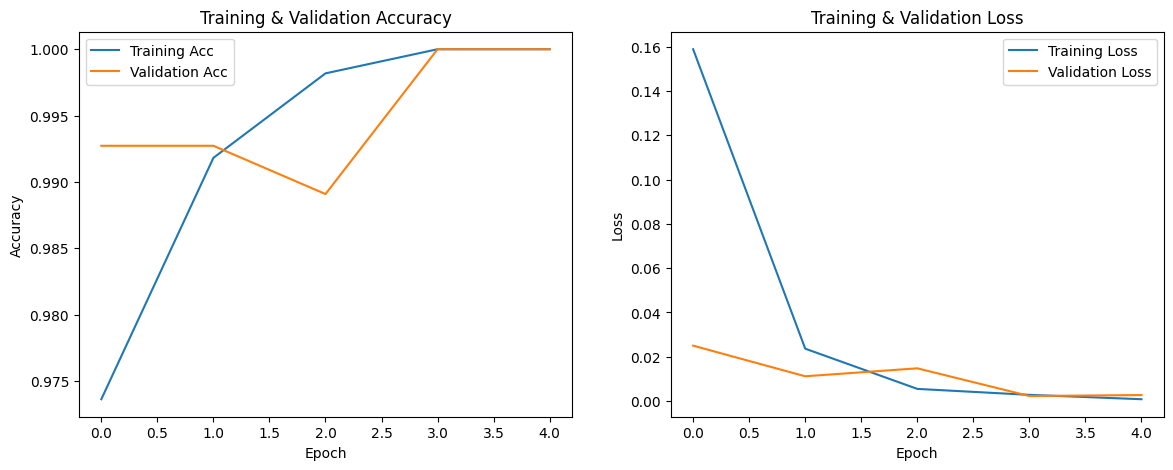

Model saved as model_cnn_final.h5


In [ ]:


checkpoint = ModelCheckpoint(
    "model_cnn.h5",            
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=5,
    batch_size=24,
    callbacks=[checkpoint, early_stop]
)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

model.save("model_cnn_final.h5")   
print("Model saved as model_cnn_final.h5")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(pre.tokenizer, f)
print("Tokenizer saved as tokenizer.pkl")


In [48]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
print("Test Accuracy:", test_acc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 9.1010e-04
Test Accuracy: 1.0


Results produced by the model are quite satisfying -very high accuracy and extremely small loss. This gives hope for a well-trained model which was able to learn all patterns of a dataset, but also rises questions of possible overfitting - maybe model would not be able to generalize well on a data not from the dataset.  

To test that 10 essays were created. 5 first ones using ChatGPT and 5 last ones - Claude. Each essay is written on a random topic and contains between 300 and 400 words. If model is able to label them as ai-written, it is able to generalize well on new data.  

In [49]:
# test on sample text
model = load_model("model_cnn_final.h5")
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

FOLDER_PATH = "./test_essays"   
MAX_LEN = 300

results = []

# Iterate over all .txt files in the folder
for filename in os.listdir(FOLDER_PATH):
    if filename.endswith(".txt"):
        file_path = os.path.join(FOLDER_PATH, filename)

        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()

        # Preprocessing (same as before)
        cleaned_text = pre.clean_text(text)
        sequence = tokenizer.texts_to_sequences([cleaned_text])
        padded_seq = pad_sequences(sequence, maxlen=MAX_LEN, padding="post")

        # Prediction
        pred_prob = model.predict(padded_seq, verbose=0)[0][0]
        pred_class = int(pred_prob > 0.5)

        label = "generated" if pred_class == 1 else "human-written"

        results.append({
            "file": filename,
            "prediction": label,
            "probability": round(float(pred_prob), 4)
        })

# Convert results to table
df = pd.DataFrame(results)

print("\nPrediction results:")
print(df.to_string(index=False))


Prediction results:
        file    prediction  probability
 essay_1.txt     generated       0.9996
essay_10.txt     generated       0.9998
 essay_2.txt     generated       0.9998
 essay_3.txt human-written       0.0336
 essay_4.txt     generated       0.9170
 essay_5.txt     generated       0.9991
 essay_6.txt     generated       1.0000
 essay_7.txt     generated       0.9998
 essay_8.txt human-written       0.4768
 essay_9.txt     generated       0.6788


As could be seen, results prove that model is able to generalize on unseen data. 8 texts are labeled as generated with very high probability, and only 2 - incorrectly as human-written.    
In case of ***essay_8*** model is not very sure and almost assigned it to the ai-written category.   
To conclude, CNN indeed could be used to distinguish between ai and human-written texts. For better performance more robust datasets should be used in training with larger variety of data as well as different architectures of the model. 